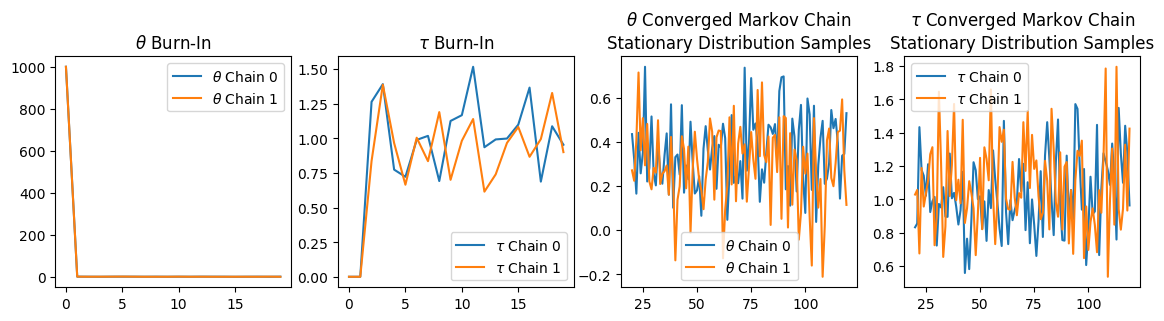

In [5]:
#Q1
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        scale_tau = np.sum((x - theta[c, g - 1])**2) / 2
        tau[c,g] = stats.gamma.rvs(a=n / 2, scale=1 / scale_tau)
        mean_theta = n * np.mean(x) / (tau[c,g] + n)
        var_theta = 1 / (tau[c,g] + n)
        theta[c,g] = stats.norm.rvs(loc=mean_theta, scale=np.sqrt(var_theta))

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

### Q2:

Prior for \
$\theta$: $\theta \sim N(\theta_0, \tau_0^2)$

Prior for\
$\tau$: $\tau \propto \tau^{\frac{\alpha}{2} - 1} e^{-\frac{\lambda}{2} \tau}$ 
Likelihood: $x_i \mid \theta, \tau \sim N(\theta, \tau^{-1}), \; i = 1, \ldots, n$

The posterior $p(\tau \mid \theta, \mathbf{x})$ is proportional to:
\[
$p(\tau \mid \theta, \mathbf{x}) \propto p(\mathbf{x} \mid \theta, \tau)p(\tau)$
\]
where
\[
$p(\mathbf{x} \mid \theta, \tau) = \prod_{i=1}^n \sqrt{\tau} e^{-\frac{\tau}{2}(x_i - \theta)^2}$
\]

Then simplify:
\[
$p(\tau \mid \theta, \mathbf{x}) \propto \tau^{\frac{n + \alpha}{2} - 1} e^{-\frac{\tau}{2} \left(\sum_{i=1}^n (x_i - \theta)^2 + \lambda\right)}$
\]

Thus:
\
$$\tau \mid \theta, \mathbf{x} \sim \text{Gamma} \left(\frac{n + \alpha}{2}, \frac{\sum_{i=1}^n (x_i - \theta)^2 + \lambda}{2}\right)
$$


The posterior $p(\theta \mid \tau, \mathbf{x})$ is proportional to:
\[
$p(\theta \mid \tau, \mathbf{x}) \propto p(\mathbf{x} \mid \theta, \tau)p(\theta)$
\]
where
\[
$p(\mathbf{x} \mid \theta, \tau) = \prod_{i=1}^n \sqrt{\tau} e^{-\frac{\tau}{2}(x_i - \theta)^2}, \quad
p(\theta) = \frac{1}{\sqrt{2\pi\tau_0^2}} e^{-\frac{(\theta - \theta_0)^2}{2\tau_0^2}}$
\]

Combining terms:
\[
$p(\theta \mid \tau, \mathbf{x}) \propto \exp \left[ -\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2 - \frac{(\theta - \theta_0)^2}{2\tau_0^2} \right]$
\]

Expand:
$$
\sum_{i=1}^n (x_i - \theta)^2 = \sum_{i=1}^n x_i^2 - 2\theta \sum_{i=1}^n x_i + n\theta^2
$$

Simplify the quadratic term:
\[
$p(\theta \mid \tau, \mathbf{x}) \propto \exp \left[ -\frac{1}{2} \left( \theta^2 (\tau n + \frac{1}{\tau_0^2}) - 2\theta \left(\tau \sum x_i + \frac{\theta_0}{\tau_0^2}\right) \right) \right]$
\]

Complete the square:
\[
$p(\theta \mid \tau, \mathbf{x}) \sim N \left(\frac{\tau \sum x_i + \frac{\theta_0}{\tau_0^2}}{\tau n + \frac{1}{\tau_0^2}}, \frac{1}{\tau n + \frac{1}{\tau_0^2}} \right)$
\]

$\alpha$ controls the prior belief about the effective sample size that the prior contributes:
- Smaller $\alpha$: Contributes less to the posterior.
- Larger $\alpha$: Implies more confidence in the prior (acts like adding $\alpha / 2$ data points to the likelihood).

$\lambda$ scales the precision of the prior:
- Smaller $\lambda$: Assumes less precision (variance) in the prior.
- Larger $\lambda$: Implies more confidence in the precision of the prior.

The ratio $\alpha / \lambda$ determines the prior mean for $\tau$.


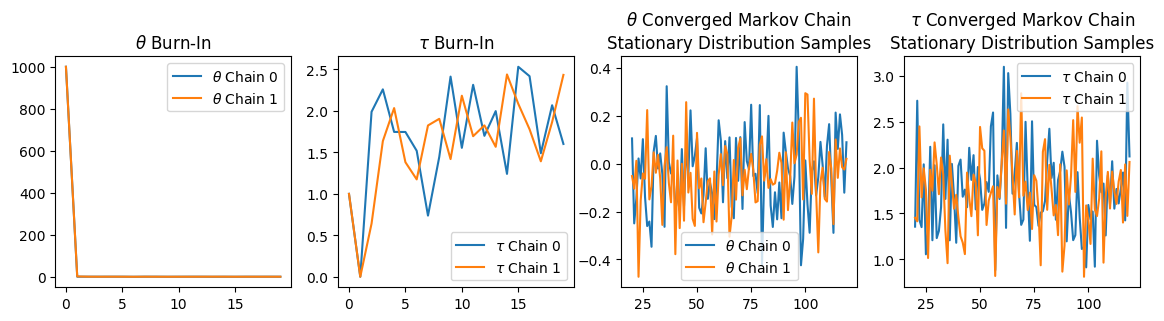

In [9]:
# Q2
n = 30  # Sample size
m = 0   
s = 1   
x = stats.norm(loc=m, scale=s).rvs(size=n)  # Simulated data

# Prior hyperparameters
theta0 = 0    # Mean of the prior distribution for theta
tau0_sq = 1   # Variance of the prior for theta
alpha = 2     # Shape parameter of the gamma prior for tau
lambda_ = 1   # Rate parameter of the gamma prior for tau

# Gibbs sampler configuration
C, G = 2, 10000  # Number of independent chains (C) and iterations (G)
theta, tau = np.zeros((C, G)), np.zeros((C, G)) # Allocate arrays to store samples
theta[:, 0] = 1000  # Set the initial value of theta
tau[:, 0] = 1       # Set the initial value of tau

# Gibbs sampling
for c in range(C):
    for g in range(1, G):
        # Update tau
        shape_tau = (n + alpha) / 2
        rate_tau = (np.sum((x - theta[c, g-1])**2) + lambda_) / 2
        tau[c, g] = stats.gamma.rvs(a=shape_tau, scale=1/rate_tau)
        
        mean_theta = (tau[c, g] * np.sum(x) + theta0 / tau0_sq) / (tau[c, g] * n + 1 / tau0_sq)
        var_theta = 1 / (tau[c, g] * n + 1 / tau0_sq)
        theta[c, g] = stats.norm.rvs(loc=mean_theta, scale=np.sqrt(var_theta))

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

### Q3:
The Multinomial-Dirichlet model extends the Beta-Binomial framework to the multinomial case. For the observed data:
$$
\mathbf{x} = (x_1, x_2, \ldots, x_k) \sim \text{Multinomial}(n, \boldsymbol{\theta})$$,
where $$ n = \sum_{i=1}^k x_i  and (\boldsymbol{\theta} = (\theta_1, \theta_2, \ldots, \theta_k) satisfies \sum_{i=1}^k \theta_i = 1.$$

### Prior Distribution:
$$
\boldsymbol{\theta} \sim \text{Dirichlet}(\alpha_1, \alpha_2, \ldots, \alpha_k).
$$

The objective is to derive the posterior distribution $$p(\boldsymbol{\theta} \mid \mathbf{x})$$.

### Using Bayes' Theorem:
\[
p$(\boldsymbol{\theta} \mid \mathbf{x}) \propto p(\mathbf{x} \mid \boldsymbol{\theta}) p(\boldsymbol{\theta}).$
\]

#### Likelihood Function:
\[
p$(\mathbf{x} \mid \boldsymbol{\theta}) = \frac{n!}{x_1!x_2!\cdots x_k!} \prod_{i=1}^k \theta_i^{x_i}.$
\]

#### Dirichlet Prior:
\[
p$(\boldsymbol{\theta}) = \frac{\Gamma\left(\sum_{i=1}^k \alpha_i\right)}{\prod_{i=1}^k \Gamma(\alpha_i)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}.$
\]

### Joint Distribution:
Combining the prior and likelihood gives:
\[
p$(\mathbf{x}, \boldsymbol{\theta}) \propto \prod_{i=1}^k \theta_i^{x_i} \prod_{i=1}^k \theta_i^{\alpha_i - 1}.$
\]

### Simplify:
\[
p$(\mathbf{x}, \boldsymbol{\theta}) \propto \prod_{i=1}^k \theta_i^{x_i + \alpha_i - 1}.$
\]

### Posterior Distribution:
The posterior is proportional to the joint distribution:
\[
p$(\boldsymbol{\theta} \mid \mathbf{x}) \propto \prod_{i=1}^k \theta_i^{x_i + \alpha_i - 1}.$
\]

This matches the form of a Dirichlet distribution:
$$
\text{Dirichlet}(\beta_1, \beta_2, \ldots, \beta_k) \propto \prod_{i=1}^k \theta_i^{\beta_i - 1},
$$
where $$\beta_i = x_i + \alpha_i.$$

### Conclusion:
The posterior distribution is:
$$
\boldsymbol{\theta} \mid \mathbf{x} \sim \text{Dirichlet}(\alpha_1 + x_1, \alpha_2 + x_2, \ldots, \alpha_k + x_k).
$$
